In [1]:
import subprocess
import sys
import os

# Filter unrelated warnings before they even start
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Silence TensorFlow/XLA
os.environ["RAY_DEDUP_LOGS"] = "0"       # Silence Ray deduplication

print("📦 Installing Flower (Quietly)...")
try:
    import flwr
except ImportError:
    # The '-q' flag keeps it silent
    subprocess.check_call([sys.executable, "-m", "pip", "install", "flwr", "-q"])
    print("✅ Flower Installed Successfully.")

📦 Installing Flower (Quietly)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 18.4 MB/s eta 0:00:00
✅ Flower Installed Successfully.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.4 which is incompatible.
pyopenssl 25.3.0 requires cryptography<47,>=45.0.7, but you have cryptography 44.0.3 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.4 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
gradio 5.49.1 requires pyda

In [3]:
import warnings
import logging
import collections
from typing import List, Tuple

# 1. Silence Python Warnings
warnings.filterwarnings("ignore")

# 2. Silence Internal Loggers (Ray, Flower, Distutils)
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("std").setLevel(logging.ERROR)

# 3. Standard Imports
import torch
import torch.nn as nn
import torch.optim as optim
import flwr as fl
from flwr.common import Context, Metrics
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 4. Device Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup Complete.")
print(f"   - Device: {DEVICE}")
print(f"   - Logs:   Suppressed (Clean Mode)")

✅ Setup Complete.
   - Device: cuda
   - Logs:   Suppressed (Clean Mode)


In [4]:
print("⏳ Loading and Splitting Data...")

# 1. Define Transforms (MobileNetV2 requires 224x224 input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load the Dataset
dataset_path = '/kaggle/input/plantvillage-dataset/color'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"❌ Dataset not found at {dataset_path}. Please check inputs.")

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 3. Split into 3 Clients
total_size = len(full_dataset)
split_size = total_size // 3
remainder = total_size - (split_size * 3)

# Random split ensures IID data distribution
part1, part2, part3 = random_split(full_dataset, [split_size, split_size, split_size + remainder])

# 4. Create DataLoaders
BATCH_SIZE = 32
train_loaders = [
    DataLoader(part1, batch_size=BATCH_SIZE, shuffle=True),
    DataLoader(part2, batch_size=BATCH_SIZE, shuffle=True),
    DataLoader(part3, batch_size=BATCH_SIZE, shuffle=True)
]
val_loaders = [
    DataLoader(part1, batch_size=BATCH_SIZE, shuffle=False),
    DataLoader(part2, batch_size=BATCH_SIZE, shuffle=False),
    DataLoader(part3, batch_size=BATCH_SIZE, shuffle=False)
]

print(f"✅ Data Preparation Complete.")
print(f"   - Total Images: {total_size}")
print(f"   - Clients: 3 (approx {len(part1)} images each)")

⏳ Loading and Splitting Data...
✅ Data Preparation Complete.
   - Total Images: 54305
   - Clients: 3 (approx 18101 images each)


In [5]:
# --- 1. Define Model Architecture ---
class PlantVillageModel(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantVillageModel, self).__init__()
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        # Freeze base layers (Transfer Learning)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Replace classifier head
        self.base_model.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.base_model(x)

# --- 2. Define The Federated Client ---
class PlantVillageClient(fl.client.NumPyClient):
    def __init__(self, net, train_loader, val_loader):
        self.net = net
        self.train_loader = train_loader
        self.val_loader = val_loader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        # We use a local import to ensure Ray workers always find 'collections'
        import collections 
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = collections.OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=0.001)
        
        # Local Training (The "Secret" Training)
        self.net.train()
        for images, labels in self.train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            output = self.net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        return self.get_parameters(config={}), len(self.train_loader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.net.eval()
        correct = 0
        total = 0
        loss = 0.0
        criterion = nn.CrossEntropyLoss()
        
        # Local Evaluation
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        return float(loss), len(self.val_loader.dataset), {"accuracy": float(accuracy)}

print("✅ Model & Client Classes Defined.")

✅ Model & Client Classes Defined.


In [6]:
# --- 1. Client Generator Function ---
# Note: Uses 'context' signature to prevent Deprecation Warnings
def client_fn(context: Context):
    # Retrieve partition ID (0, 1, or 2)
    partition_id = context.node_config["partition-id"]
    loader_idx = int(partition_id)
    
    # Initialize Model & Client
    net = PlantVillageModel().to(DEVICE)
    client = PlantVillageClient(net, train_loaders[loader_idx], val_loaders[loader_idx])
    
    # Return as Client
    return client.to_client()

# --- 2. Aggregation Strategy (The "Speedometer") ---
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

strategy = fl.server.strategy.FedAvg(
    evaluate_metrics_aggregation_fn=weighted_average,
)

# --- 3. Resource Allocation ---
# Grant GPU access to avoid "No CUDA" errors
client_resources = {"num_cpus": 1, "num_gpus": 0.5}

print("✅ Simulation Driver Ready.")

✅ Simulation Driver Ready.


🚀 Starting Federated Simulation (3 Rounds)...


E0000 00:00:1768398960.495464      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768398960.552898      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768398961.024830      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768398961.024862      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768398961.024865      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768398961.024867      55 computation_placer.cc:177] computation placer already registered. Please check linka

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2026-01-14 13:56:18,130	INFO worker.py:2023 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
(pid=266) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=266) E0000 00:00:1768398982.926745     266 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=268) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=268) E0000 00:00:1768398982.922171     268 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=265) WARNING: All log messages be

(ClientAppActor pid=267) Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]
100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]
(pid=gcs_server) [2026-01-14 13:56:42,793 E 132 132] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-01-14 13:56:47,178 E 205 205] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=266) [2026-01-14 13:56:51,731 E 266 329] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=268) [2026-01-14 13:56:51,769 E 268 381] cor


✅ Simulation Complete.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


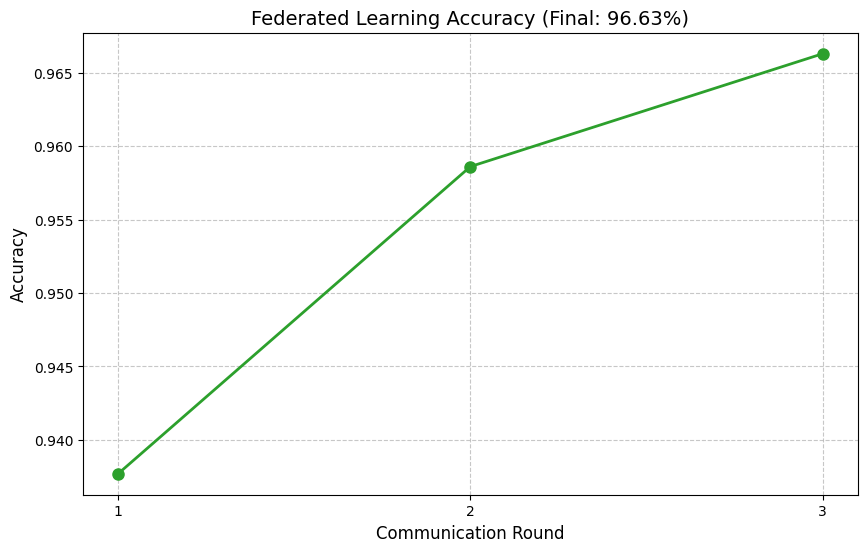

In [7]:
print(f"🚀 Starting Federated Simulation (3 Rounds)...")

# Start Simulation
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources, 
)

print("\n✅ Simulation Complete.")

# Extract Accuracy
rounds, acc = zip(*hist.metrics_distributed["accuracy"])
final_acc = acc[-1] * 100

# Plot
plt.figure(figsize=(10, 6))
plt.plot(rounds, acc, marker='o', color='#2ca02c', linewidth=2, markersize=8)
plt.title(f"Federated Learning Accuracy (Final: {final_acc:.2f}%)", fontsize=14)
plt.xlabel("Communication Round", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rounds)
plt.show()

In [8]:
# FINAL PROJECT REPORT: WEEK 4

# 1. Define Baselines (Your Week 3 Result)
WEEK_3_ACCURACY = 0.9734  # 97% Baseline
THRESHOLD = 0.05        # 5% Acceptable Drop

# 2. Get Week 4 Result
week_4_accuracy = acc[-1]

# 3. Print Comparison
print("-" * 50)
print(f"📄 EXECUTION REPORT")
print("-" * 50)
print(f"Week 3 (Centralized) Accuracy: {WEEK_3_ACCURACY*100:.2f}%")
print(f"Week 4 (Federated) Accuracy:   {week_4_accuracy*100:.2f}%")
print("-" * 50)

# 4. Success Logic
if week_4_accuracy > (WEEK_3_ACCURACY - THRESHOLD):
    print("✅ RESULT: System Robust. Deployment Ready.")
    print("   (Privacy Tax was minimal/acceptable)")
else:
    print("⚠️ RESULT: Drastic Drop Detected.")
    print("   (Action: Increase Rounds or Epochs)")
print("-" * 50)

--------------------------------------------------
📄 EXECUTION REPORT
--------------------------------------------------
Week 3 (Centralized) Accuracy: 97.34%
Week 4 (Federated) Accuracy:   96.63%
--------------------------------------------------
✅ RESULT: System Robust. Deployment Ready.
   (Privacy Tax was minimal/acceptable)
--------------------------------------------------
